In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import shap
import polars as pl

In [2]:
# constants
filepath = "./9417_imputed_data"
device = "cuda" if torch.cuda.is_available() else "cpu"
# how many data points are in 2024
testsplit = 7110

device

'cuda'

In [3]:
# read in all temporal data datafiles
df_lag_base = pl.read_ipc(filepath + "/denormalised, with lags.parquet").to_pandas()
df_lag_01 = pl.read_ipc(filepath + "/min-max scaled, with lags.parquet").to_pandas()
df_lag_z = pl.read_ipc(filepath + "/Z-score normalised, with lags.parquet").to_pandas()

In [12]:
# extract base datafiles without temporal data
cols = [
   'DateTime', 'Date', 'Time', 'linear_dt', 'sin_time_of_year',
   'cos_time_of_year', 'is_mon', 'is_tue', 'is_wed', 'is_thu', 'is_fri',
   'is_sat', 'is_sun', 'is_weekday', 'sin_time_of_week',
   'cos_time_of_week', 'sin_hour_of_day', 'cos_hour_of_day', 'CO(GT)',
   'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
   'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH','AH'
]
df_nolag_base = pl.read_ipc(filepath + "/denormalised, with lags.parquet").select(cols).to_pandas()
df_nolag_01 = pl.read_ipc(filepath + "/min-max scaled, with lags.parquet").select(cols).to_pandas()
df_nolag_z = pl.read_ipc(filepath + "/Z-score normalised, with lags.parquet").select(cols).to_pandas()

In [13]:
# select the file to use
X = df_nolag_z

In [14]:
# create discretised y labels based on non-normalised CO ground truth
y = []
for i in df_nolag_base["CO(GT)"]:
    co = round(i,4)
    y.append(0 if co < 1.5 else 1 if co < 2.5 else 2)
y = pd.get_dummies(y, dtype=float)
y_nontest = y[:testsplit]
y_test = y[testsplit:]

In [16]:
print(X.columns)

Index(['DateTime', 'Date', 'Time', 'linear_dt', 'sin_time_of_year',
       'cos_time_of_year', 'is_mon', 'is_tue', 'is_wed', 'is_thu', 'is_fri',
       'is_sat', 'is_sun', 'is_weekday', 'sin_time_of_week',
       'cos_time_of_week', 'sin_hour_of_day', 'cos_hour_of_day', 'CO(GT)',
       'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH'],
      dtype='object')


In [17]:
# drop non numerical data (which are represented again by other variables in sin-cos encoding or linear encoding)
X.drop(["DateTime", "Date", "Time"], axis="columns", inplace=True, errors="ignore")

# nontest is further split into training and validation by training function later
X_nontest = X.iloc[:testsplit]
X_test = X.iloc[testsplit:]

In [18]:
print(X.shape, y.shape)
print(X_nontest.shape, y_nontest.shape)
print(X_test.shape, y_test.shape)

(9357, 28) (9357, 3)
(7110, 28) (7110, 3)
(2247, 28) (2247, 3)


In [19]:
# combine X and y to synchronously drop entries with NA (only present in data with lag, as it requires time to begin moving window averages and lookback windows)
nontest_combined = pd.concat([X_nontest, y_nontest], axis=1)
test_combined = pd.concat([X_test, y_test], axis=1)

nontest_combined = nontest_combined.dropna()
test_combined = test_combined.dropna()

y_nontest = nontest_combined[[0, 1, 2]]
X_nontest = nontest_combined.drop([0, 1, 2], axis="columns", errors="ignore")
y_test = test_combined[[0, 1, 2]]
X_test = test_combined.drop([0, 1, 2], axis="columns", errors="ignore")

In [20]:
print(X_nontest.shape, y_nontest.shape)
print(X_test.shape, y_test.shape)

(7110, 28) (7110, 3)
(2247, 28) (2247, 3)


# Testing

In [ ]:
# plot confusion matrix and graph y_predicted against y_true
def confusion_and_graph(t, y_true, y_predicted, method):
    count = len(y_true)
    y_true = y_true.to("cpu")
    y_predicted = y_predicted.to("cpu")
    correct = y_true.eq(y_predicted).sum().item()
    accuracy = correct / count * 100
    print(f"total={count}", f"correct={correct}", f"{method} accuracy={accuracy:.2f}%")
    print("confusion matrix (vertical axis=true, horizontal=predicted):")
    for i in range(3):
        filter = y_true == i
        filtered = y_predicted[filter.nonzero()]
        filtered = torch.tensor([out[0] for out in filtered])
        print(torch.bincount(filtered, minlength=3))

    # limit number of predictions vs ground truth displayed on graph for visibility
    limited = min(count, 100)
    hour = range(limited)
    plt.plot(hour, y_true[:limited], label="True", color="blue", linestyle="-")
    plt.plot(hour, y_predicted[:limited], label="Predicted", color="red", linestyle="-")
    plt.xlabel("Hours")
    plt.ylabel("CO Classification")
    plt.title(f"{method} CO Predictions t={t}")
    plt.legend()
    plt.show()

In [ ]:
# baseline confusion matrix, accuracy, and graph naive output vs true
def compare_baseline(t, n_test):
    print(f"Compared against baseline naive t={t}:")
    
    y_baseline = torch.tensor(np.array(y_nontest.iloc[-(n_test + t):], dtype=np.float32)).argmax(dim=1)
    # check if there are significant biases
    print(y_baseline.unique(return_counts=True))
    print()

    y_true = y_baseline[t:]
    y_predicted = y_baseline[:-t]

    confusion_and_graph(t, y_true, y_predicted, "naive")

In [ ]:
# test a model using a dataloader
def test_network(model, loader):
    model.eval()
    total_items = 0
    total_correct = 0
    with torch.no_grad():
        for (items, labels) in loader:
            items, labels = items.to(device), labels.to(device)
            preds = model(items)
            output = preds.argmax(dim=1)

            total_items += labels.size(0)
            total_correct += output.eq(labels.argmax(dim=1)).sum().item()

    model_accuracy = 100.0 * total_correct / total_items
    print(f"test {model_accuracy:.2f}%")
    model.train()
    return model_accuracy

In [ ]:
# train a model based on the given hyperparameters and dataloaders (testloader is validation set)
def train_network(model, epochs, loss_f, optim, trainloader, testloader):
    epoch_x = []
    train_accs = []
    valid_accs = []
    for epoch in range(epochs):
        total_loss = 0
        total_items = 0
        total_correct = 0

        for (items, labels) in trainloader:
            items, labels = items.to(device), labels.to(device)
            preds = model(items)
            loss = loss_f(preds, labels)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            output = preds.argmax(dim=1)

            total_loss += loss.item()
            total_items += labels.size(0)
            total_correct += output.eq(labels.argmax(dim=1)).sum().item()

        model_accuracy = total_correct / total_items * 100
        print(f"ep {epoch+1}, loss: {total_loss:.2f}, train {model_accuracy:.2f}%", end=", ")
        
        epoch_x.append(epoch)
        train_accs.append(model_accuracy)
        valid_accs.append(test_network(model, testloader))

    plt.plot(epoch_x, train_accs, label="Train", color="blue", linestyle="-")
    plt.plot(epoch_x, valid_accs, label="Validation", color="red", linestyle="-")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

In [ ]:
# controller function generating data train/validation split in temporal order with t-shifted horizons
def t_temporal_prediction(model, t, test_proportion, epochs, batch_size, lr, way, evaluate):
    X_t_shifted = X_nontest.iloc[:-t]
    y_t_shifted = y_nontest.iloc[t:]
    n_total = X_t_shifted.shape[0]
    n_train = int(n_total * (1 - test_proportion))
    n_test = n_total - n_train
    
    X_train = torch.tensor(np.array(X_t_shifted[:n_train], dtype=np.float32))
    y_train = torch.tensor(np.array(y_t_shifted[:n_train], dtype=np.float32))
    X_valid = torch.tensor(np.array(X_t_shifted[n_train:], dtype=np.float32))
    y_valid = torch.tensor(np.array(y_t_shifted[n_train:], dtype=np.float32))

    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    valid_data = torch.utils.data.TensorDataset(X_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    loss_f = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    print("Start training...")
    print(f"total={n_total}", f"n_train={n_train}", f"n_test={n_test}")
    print()
    train_network(model, epochs, loss_f, optim, trainloader, validloader)
    print()

    if evaluate:
        print(f"Final model performance t={t}")
        y_predicted = None
        model.eval()
        with torch.no_grad():
            items = X_valid.to(device)
            preds = model(items)
            y_predicted = preds.argmax(dim=1)
        model.train()
        confusion_and_graph(t, y_valid.argmax(dim=1), y_predicted, way)

        compare_baseline(t, n_test)

In [ ]:
# plot a SHAP beeswarm graph for each classification output, as well as overall effects
def shap_graph(model, name):
    model.eval()

    background_np = np.array(X_nontest.sample(100, random_state=42), dtype=np.float32)
    explain_np = np.array(X_test.sample(500, random_state=42), dtype=np.float32)

    explainer = shap.GradientExplainer(model, torch.tensor(background_np).to(device))
    shap_values_raw = explainer.shap_values(torch.tensor(explain_np).to(device))
    shap_values_by_class = [shap_values_raw[:, :, i] for i in range(3)]

    for class_id, shap_values in enumerate(shap_values_by_class):   
        plt.title(f"SHAP: feature impacts for class={class_id} - {name}")
        shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)

    # weighted overall SHAP effects
    final = []
    for a in shap_values_raw:
        temp = []
        for b in a:
            val = 0
            val += b[0] * -1.5
            val += b[1] * 0.5
            val += b[2] * 1
            temp.append(val)
        final.append(temp)
    final = np.array(final)

    plt.title(f"SHAP: overall feature impacts for {name}")
    shap.summary_plot(final, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)

## Simple dense nn

In [71]:
class Dense(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_nontest.shape[-1], 256),
            nn.Dropout(0.3),
            nn.LeakyReLU(1e-2),
            nn.Linear(256, 32),
            nn.Dropout(0.3),
            nn.LeakyReLU(1e-2),
            nn.Linear(32, 3)
        )

    def forward(self, input):
        return self.layers(input)

In [ ]:
# training constant and hyperparameter
test_proportion = 0.15
batch_size = 32

Start training...
total=7109 n_train=6042 n_test=1067

ep 1, loss: 204.16, train 39.21%, test 35.61%
ep 2, loss: 195.60, train 53.29%, test 61.20%
ep 3, loss: 186.81, train 62.02%, test 69.07%
ep 4, loss: 177.62, train 66.78%, test 69.54%
ep 5, loss: 169.83, train 69.12%, test 69.17%
ep 6, loss: 162.83, train 69.63%, test 69.73%
ep 7, loss: 156.42, train 70.49%, test 70.48%
ep 8, loss: 150.70, train 70.85%, test 71.23%
ep 9, loss: 146.33, train 70.61%, test 71.32%
ep 10, loss: 141.92, train 71.65%, test 71.98%
ep 11, loss: 138.18, train 70.82%, test 72.45%
ep 12, loss: 134.93, train 72.13%, test 72.91%
ep 13, loss: 132.41, train 71.96%, test 73.29%
ep 14, loss: 130.62, train 71.85%, test 73.66%
ep 15, loss: 127.37, train 72.84%, test 73.20%
ep 16, loss: 125.54, train 72.76%, test 73.57%
ep 17, loss: 123.27, train 73.58%, test 73.57%
ep 18, loss: 122.33, train 74.10%, test 73.95%
ep 19, loss: 122.09, train 73.75%, test 74.04%
ep 20, loss: 120.31, train 74.20%, test 74.32%
ep 21, loss: 1

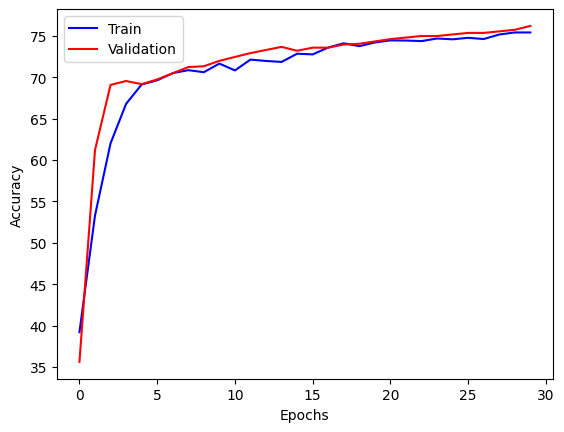


Final model performance t=1
total=1067 correct=813 dense accuracy=76.19%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([264,  46,  10])
tensor([ 50, 119,  88])
tensor([ 12,  48, 430])


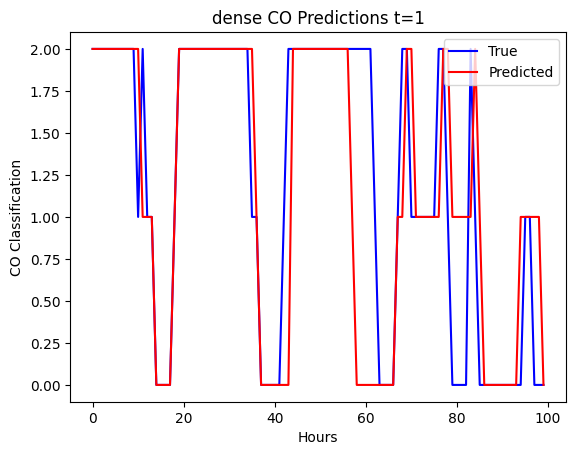

Compared against baseline naive t=1:
(tensor([0, 1, 2]), tensor([320, 257, 491]))

total=1067 correct=831 naive accuracy=77.88%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([266,  52,   2])
tensor([ 43, 145,  69])
tensor([ 10,  60, 420])


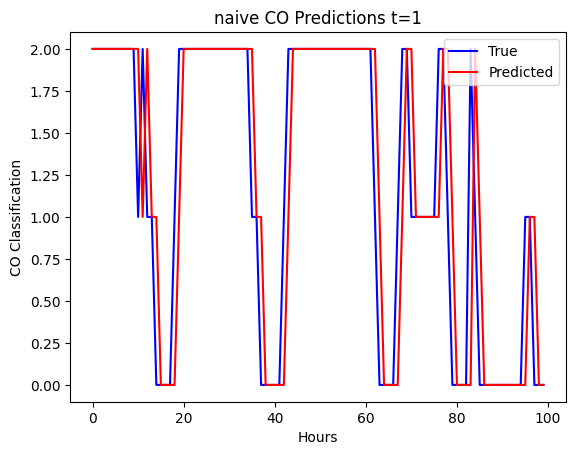

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


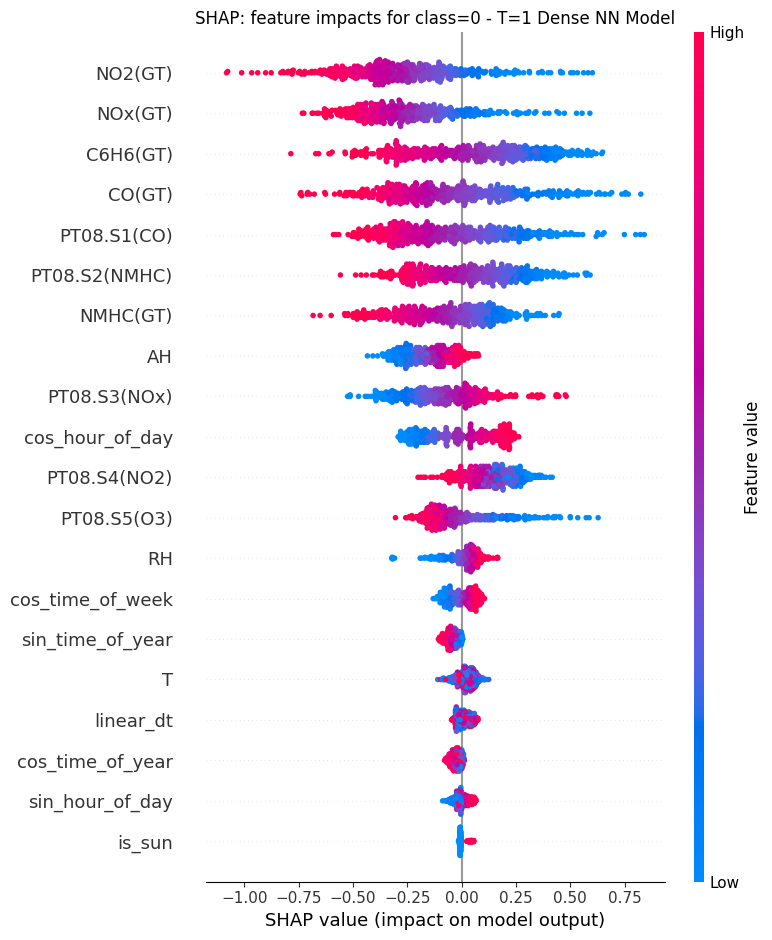

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


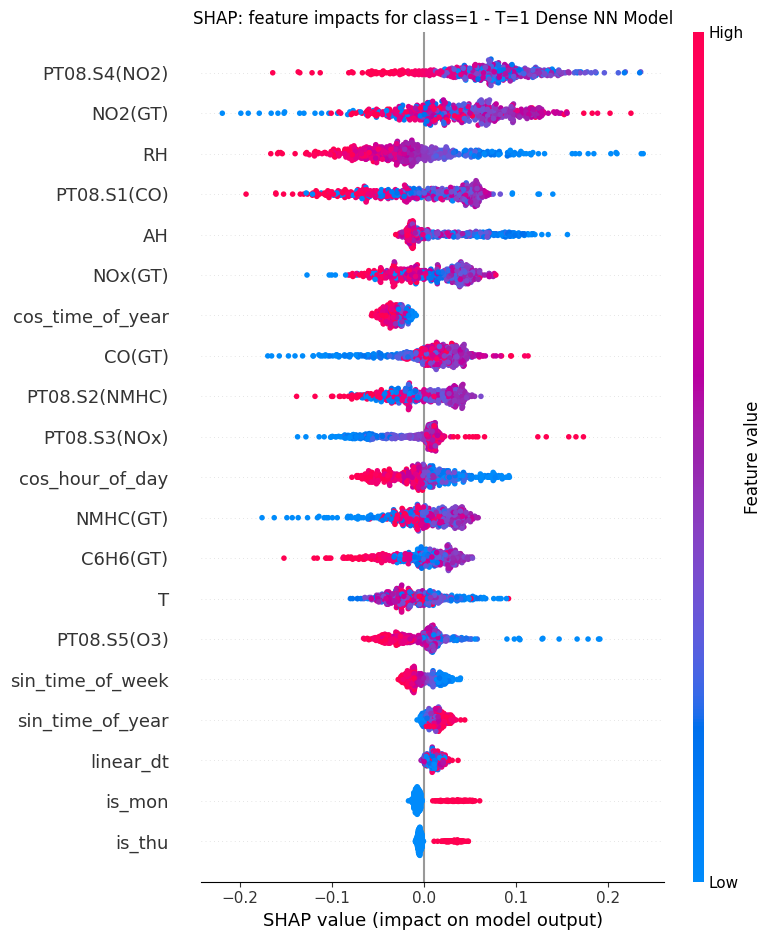

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


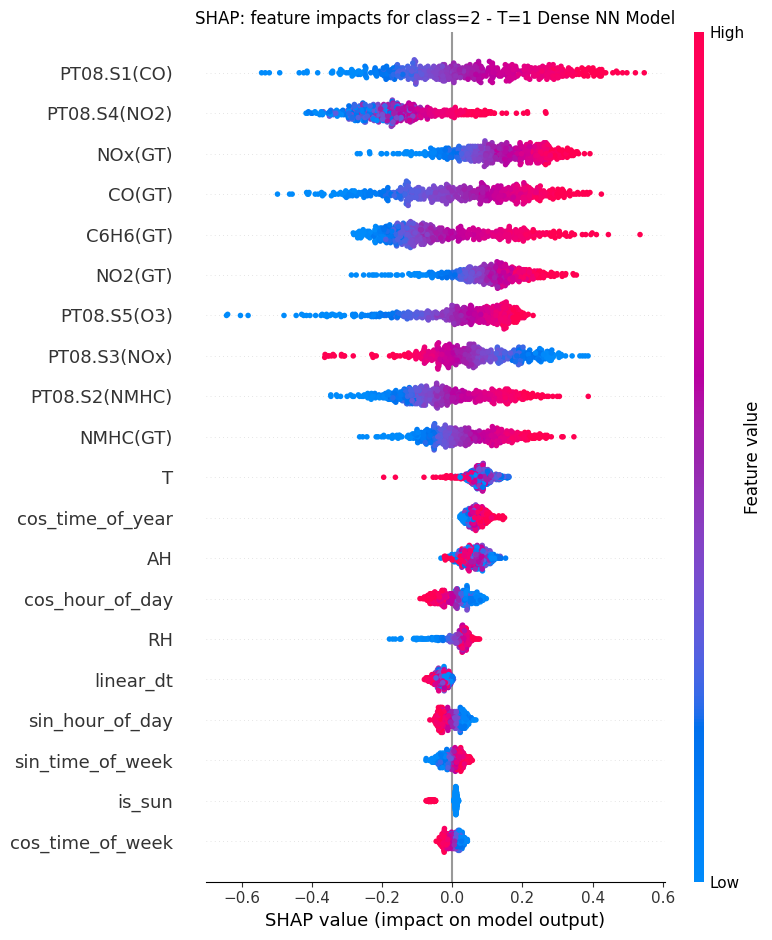

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


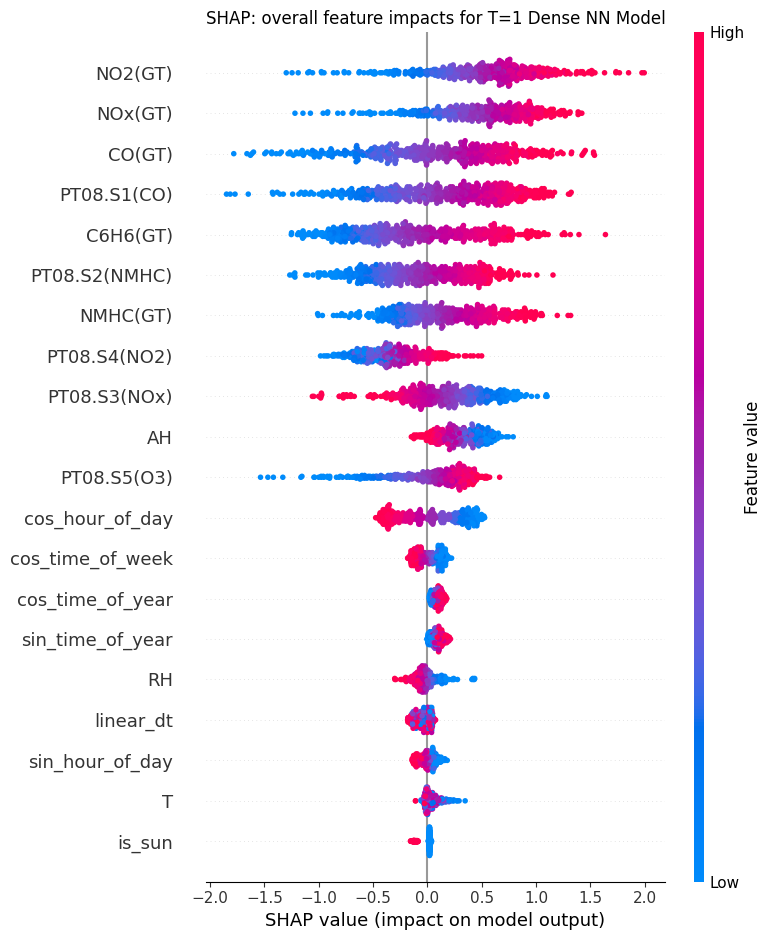

In [73]:
t = 1
epochs = 30
lr = 1e-5

t1_dense_model = Dense().to(device)
t_temporal_prediction(t1_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t1_dense_model, f"T={t} Dense NN Model")

Start training...
total=7104 n_train=6038 n_test=1066

ep 1, loss: 208.09, train 31.68%, test 33.30%
ep 2, loss: 206.82, train 36.44%, test 34.80%
ep 3, loss: 205.56, train 38.70%, test 35.74%
ep 4, loss: 204.37, train 42.00%, test 37.90%
ep 5, loss: 202.95, train 44.82%, test 40.06%
ep 6, loss: 201.87, train 45.93%, test 42.68%
ep 7, loss: 201.16, train 46.12%, test 45.31%
ep 8, loss: 200.03, train 47.35%, test 48.31%
ep 9, loss: 198.48, train 49.50%, test 50.66%
ep 10, loss: 197.10, train 49.87%, test 52.44%
ep 11, loss: 196.18, train 49.62%, test 52.63%
ep 12, loss: 194.68, train 51.31%, test 54.32%
ep 13, loss: 193.26, train 51.37%, test 55.25%
ep 14, loss: 191.77, train 52.20%, test 56.38%
ep 15, loss: 190.25, train 52.67%, test 57.22%
ep 16, loss: 188.83, train 53.05%, test 57.79%
ep 17, loss: 187.35, train 53.03%, test 57.97%
ep 18, loss: 185.96, train 54.14%, test 57.88%
ep 19, loss: 184.68, train 54.49%, test 58.44%
ep 20, loss: 183.02, train 55.27%, test 59.01%
ep 21, loss: 1

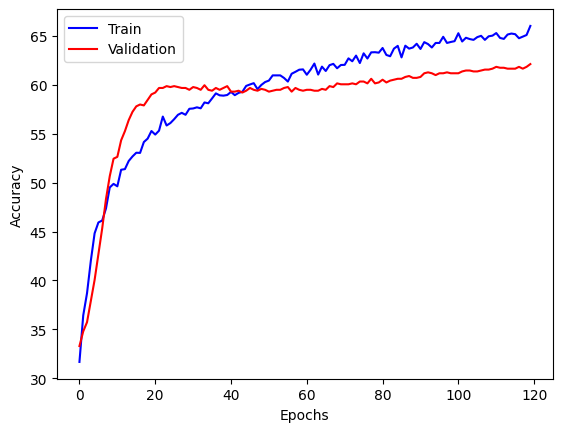


Final model performance t=6
total=1066 correct=662 dense accuracy=62.10%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([234,  20,  66])
tensor([103,  56,  98])
tensor([ 56,  61, 372])


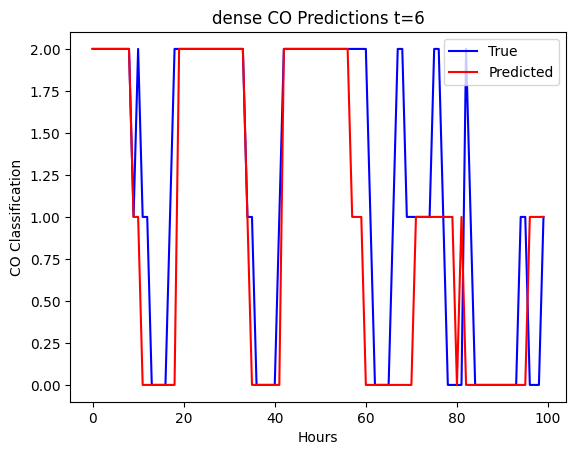

Compared against baseline naive t=6:
(tensor([0, 1, 2]), tensor([320, 257, 495]))

total=1066 correct=467 naive accuracy=43.81%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([133, 101,  86])
tensor([ 74,  54, 129])
tensor([107, 102, 280])


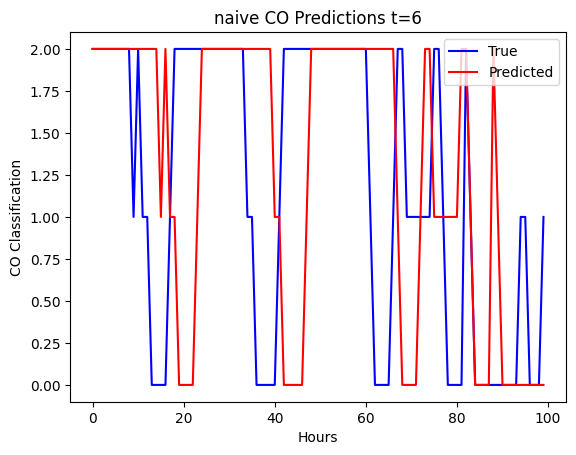

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


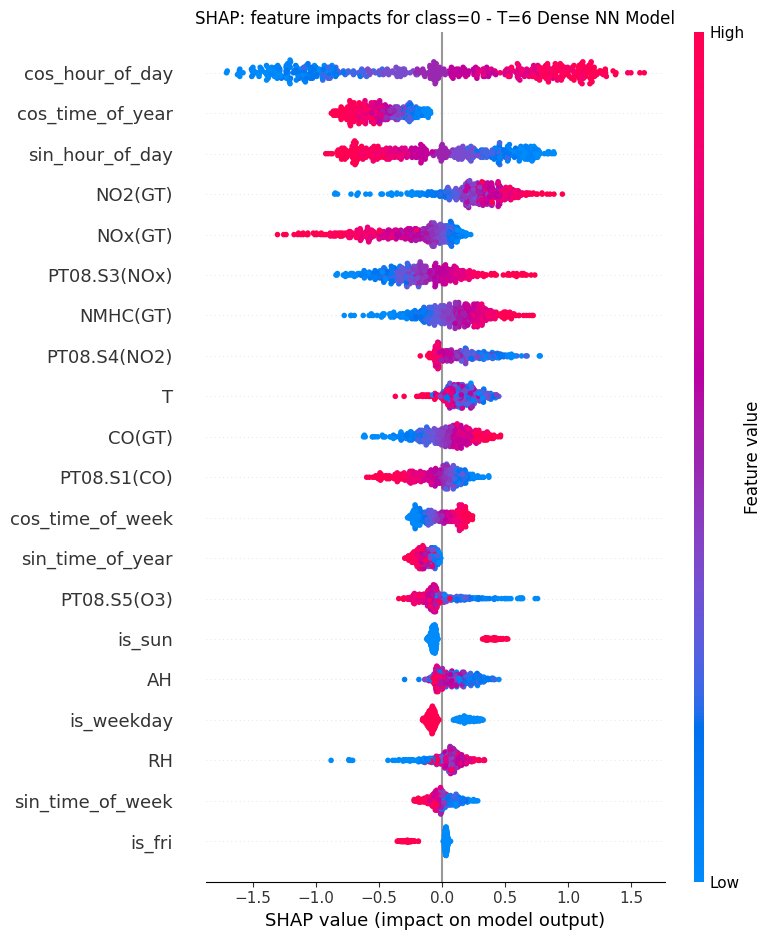

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


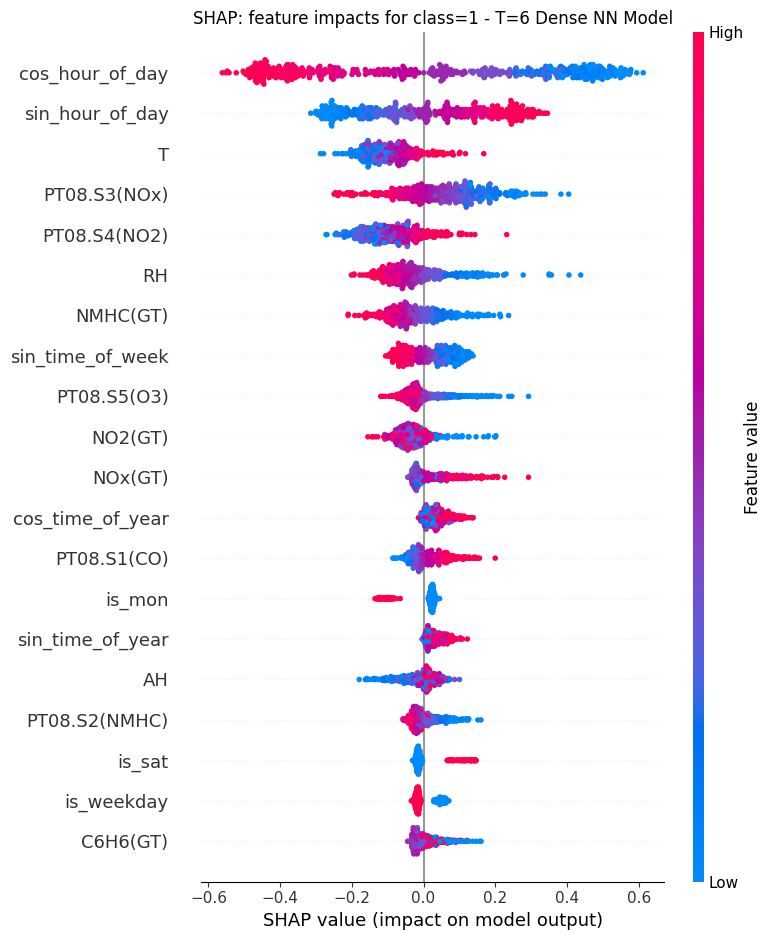

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


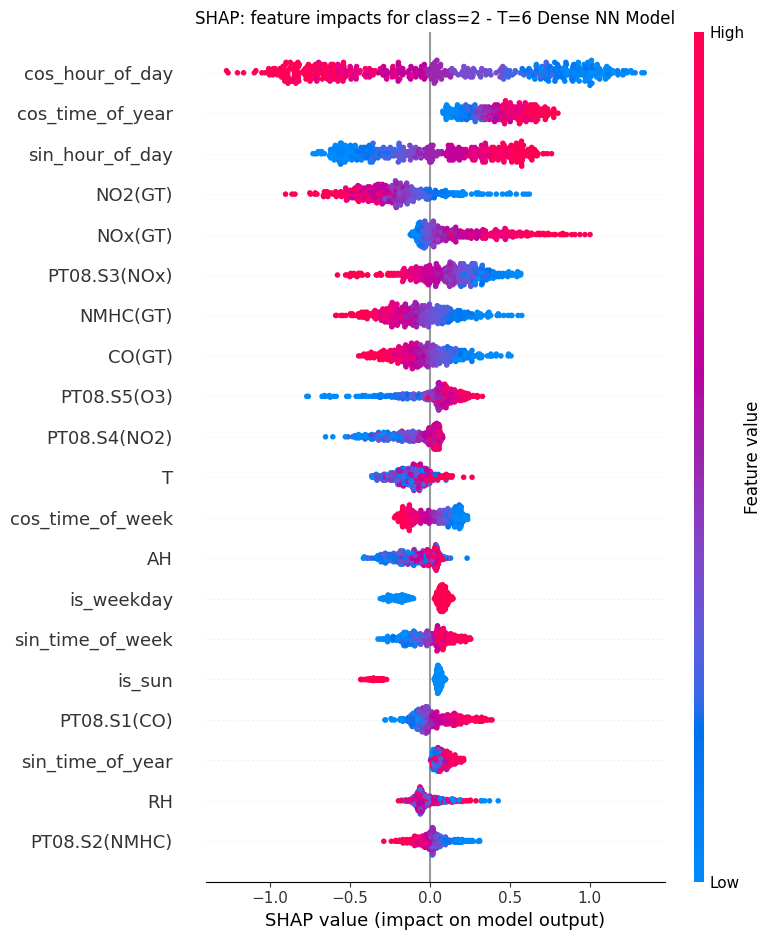

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


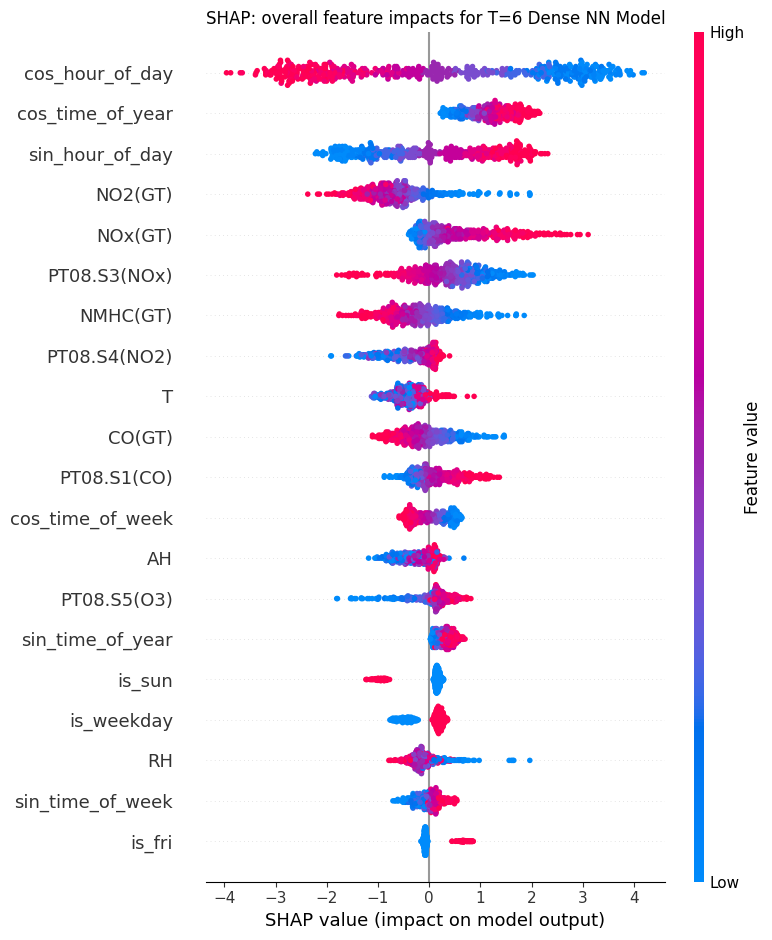

In [74]:
t = 6
epochs = 120
lr = 1e-5

t6_dense_model = Dense().to(device)
t_temporal_prediction(t6_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t6_dense_model, f"T={t} Dense NN Model")

Start training...
total=7098 n_train=6033 n_test=1065

ep 1, loss: 212.44, train 29.11%, test 24.23%
ep 2, loss: 208.63, train 31.11%, test 24.32%
ep 3, loss: 206.13, train 33.98%, test 28.64%
ep 4, loss: 203.61, train 38.41%, test 36.06%
ep 5, loss: 201.40, train 41.85%, test 41.78%
ep 6, loss: 199.20, train 44.29%, test 44.13%
ep 7, loss: 197.35, train 46.66%, test 45.63%
ep 8, loss: 194.82, train 47.97%, test 46.85%
ep 9, loss: 193.41, train 48.63%, test 47.79%
ep 10, loss: 191.23, train 50.37%, test 48.45%
ep 11, loss: 190.03, train 50.97%, test 49.20%
ep 12, loss: 188.73, train 51.35%, test 49.58%
ep 13, loss: 186.70, train 53.04%, test 50.33%
ep 14, loss: 184.84, train 53.79%, test 50.61%
ep 15, loss: 184.38, train 53.59%, test 50.70%
ep 16, loss: 182.75, train 54.50%, test 50.61%
ep 17, loss: 181.93, train 54.55%, test 50.89%
ep 18, loss: 180.32, train 55.96%, test 51.46%
ep 19, loss: 179.18, train 56.27%, test 51.64%
ep 20, loss: 178.82, train 56.12%, test 51.92%
ep 21, loss: 1

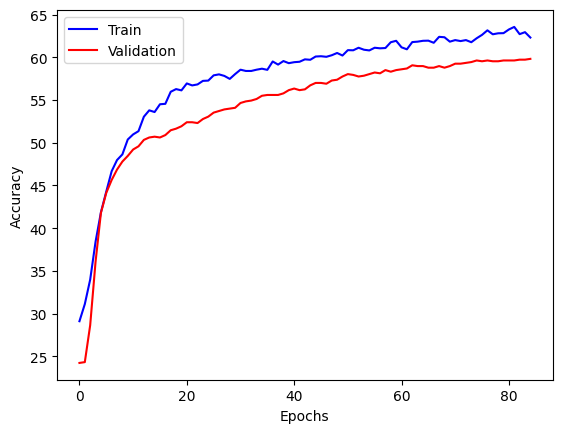


Final model performance t=12
total=1065 correct=637 dense accuracy=59.81%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([207,   8, 105])
tensor([100,  18, 139])
tensor([ 54,  22, 412])


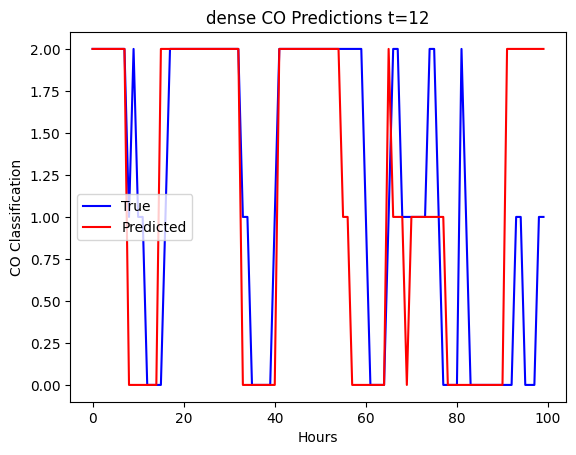

Compared against baseline naive t=12:
(tensor([0, 1, 2]), tensor([325, 257, 495]))

total=1065 correct=376 naive accuracy=35.31%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([ 96,  79, 145])
tensor([ 71,  58, 128])
tensor([146, 120, 222])


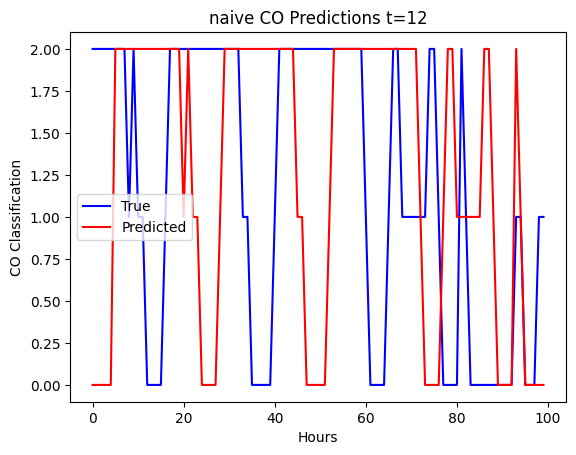

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


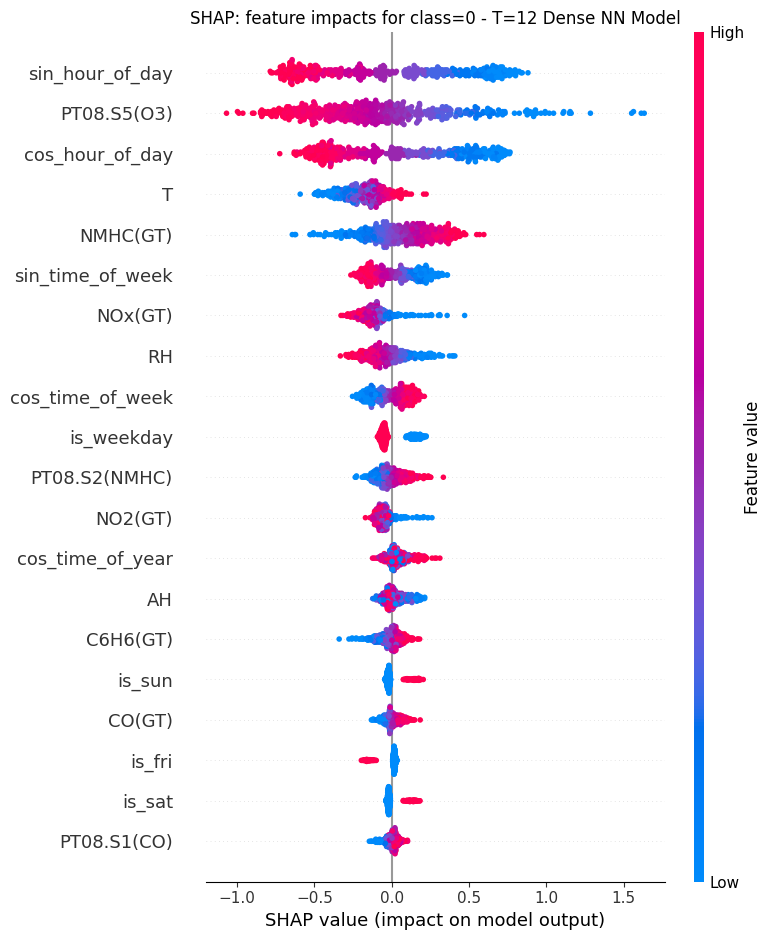

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


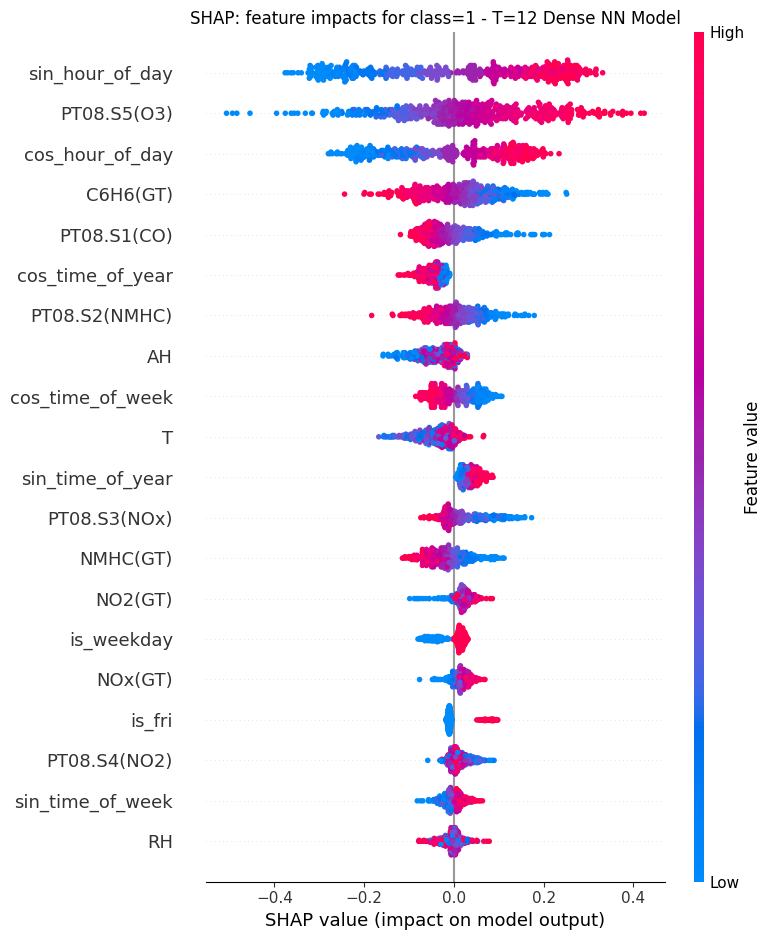

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


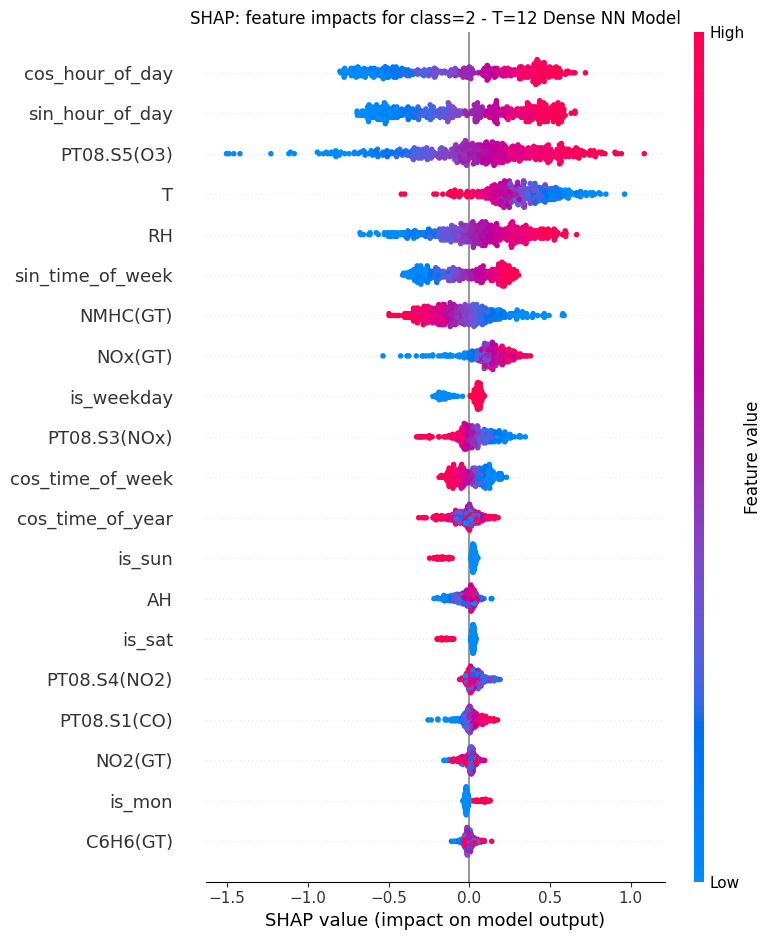

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


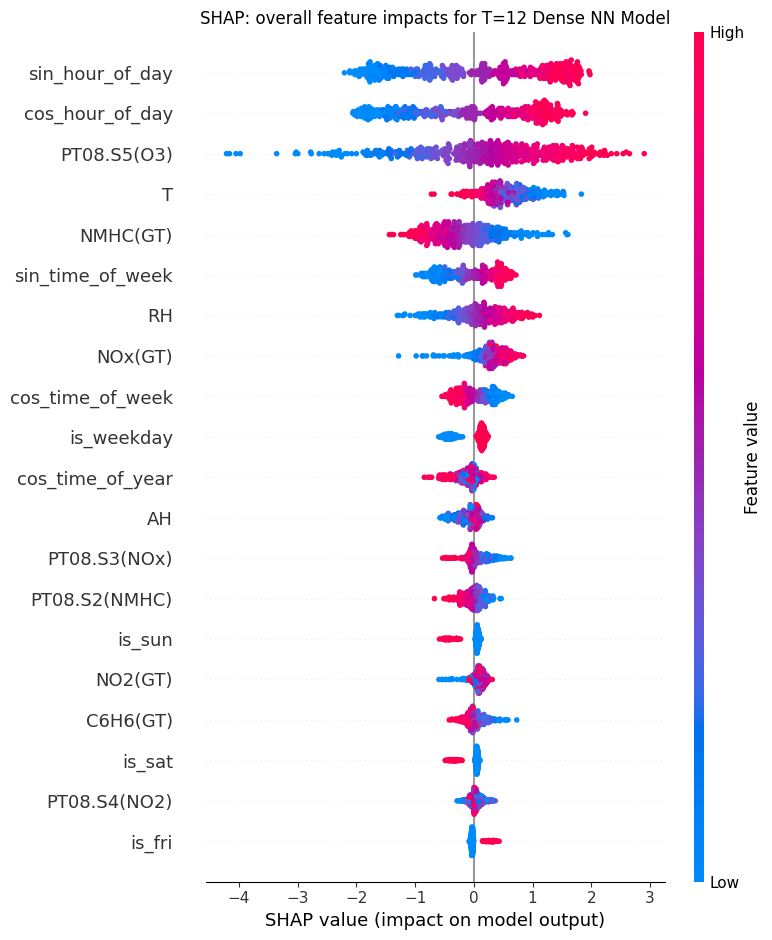

In [75]:
t = 12
epochs = 85
lr = 1e-5

t12_dense_model = Dense().to(device)
t_temporal_prediction(t12_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t12_dense_model, f"T={t} Dense NN Model")

Start training...
total=7086 n_train=6023 n_test=1063

ep 1, loss: 208.26, train 32.48%, test 49.11%
ep 2, loss: 203.19, train 41.29%, test 58.89%
ep 3, loss: 198.72, train 50.81%, test 60.87%
ep 4, loss: 194.02, train 54.94%, test 60.96%
ep 5, loss: 189.78, train 56.40%, test 60.40%
ep 6, loss: 184.94, train 57.50%, test 60.40%
ep 7, loss: 180.75, train 57.89%, test 60.49%
ep 8, loss: 176.95, train 58.24%, test 60.58%
ep 9, loss: 174.17, train 58.39%, test 60.58%
ep 10, loss: 171.43, train 58.54%, test 60.68%
ep 11, loss: 169.68, train 58.84%, test 60.58%
ep 12, loss: 167.54, train 58.96%, test 60.68%
ep 13, loss: 165.76, train 59.34%, test 60.87%
ep 14, loss: 164.46, train 59.37%, test 61.05%
ep 15, loss: 163.11, train 59.65%, test 61.05%
ep 16, loss: 162.09, train 59.90%, test 61.15%
ep 17, loss: 160.68, train 60.85%, test 60.96%
ep 18, loss: 159.74, train 61.31%, test 61.34%
ep 19, loss: 158.73, train 61.12%, test 61.34%
ep 20, loss: 158.56, train 61.22%, test 61.43%
ep 21, loss: 1

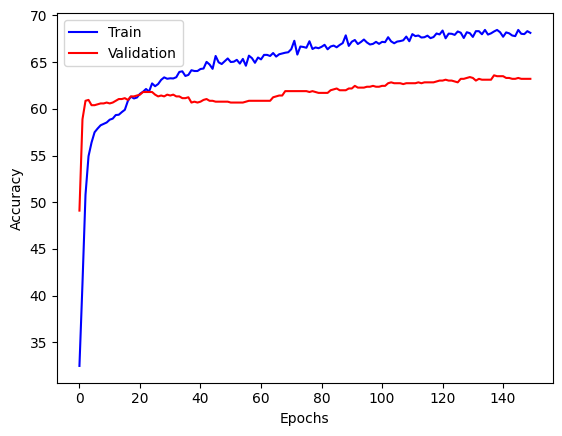


Final model performance t=24
total=1063 correct=672 dense accuracy=63.22%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([210,  58,  52])
tensor([ 66,  60, 131])
tensor([ 18,  66, 402])


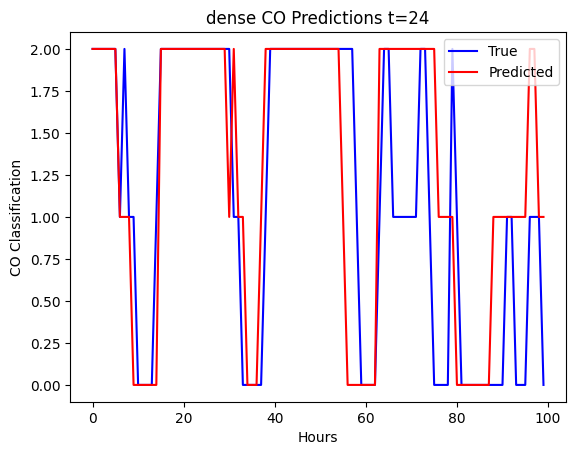

Compared against baseline naive t=24:
(tensor([0, 1, 2]), tensor([326, 261, 500]))

total=1063 correct=622 naive accuracy=58.51%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([196,  66,  58])
tensor([ 69,  86, 102])
tensor([ 37, 109, 340])


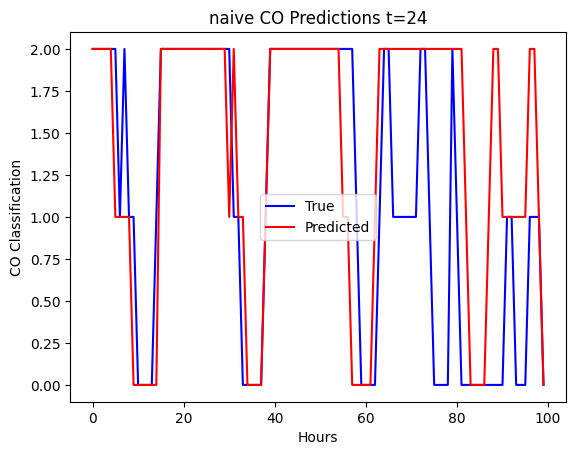

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


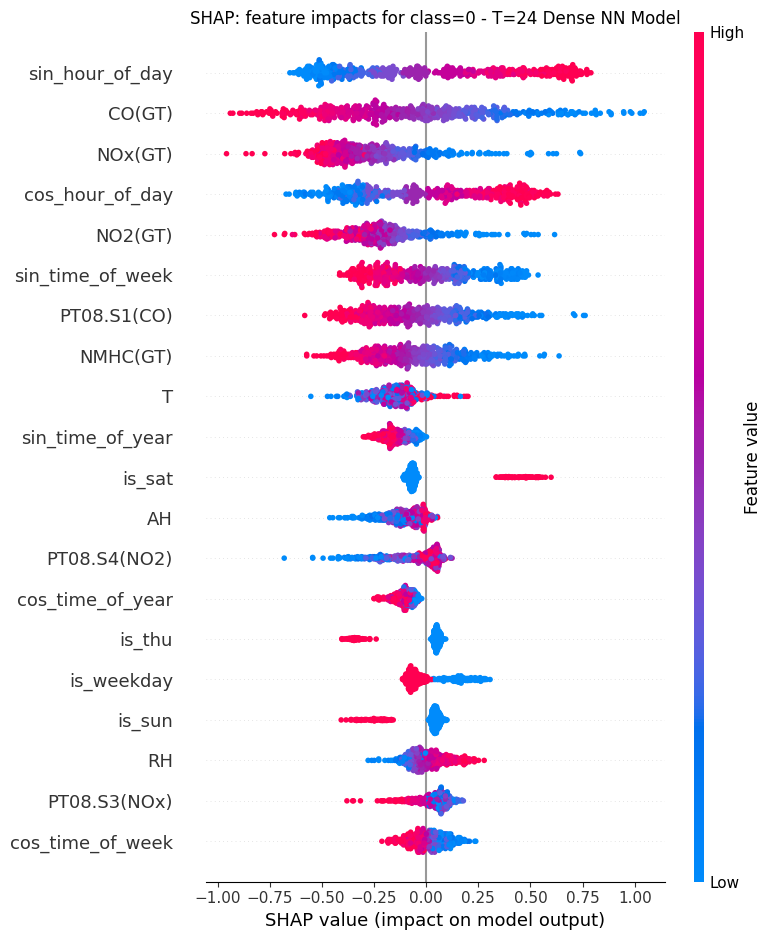

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


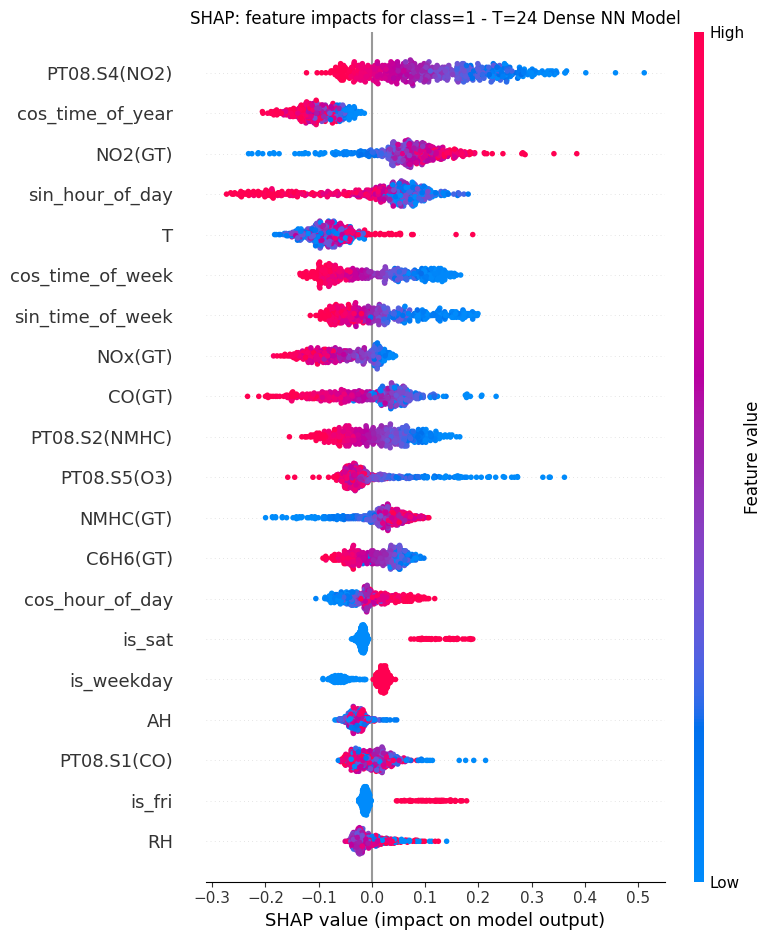

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


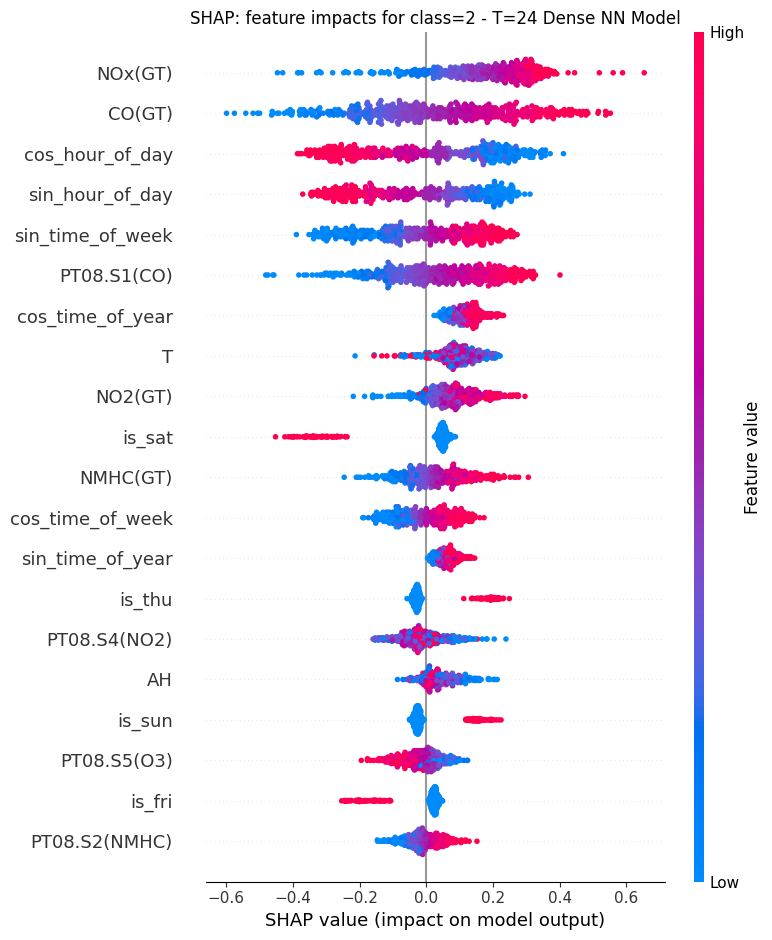

C:\Users\bread\AppData\Local\Temp\ipykernel_11240\2286680506.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final, explain_np, feature_names=list(X_test.columns), plot_type="dot", show=True)


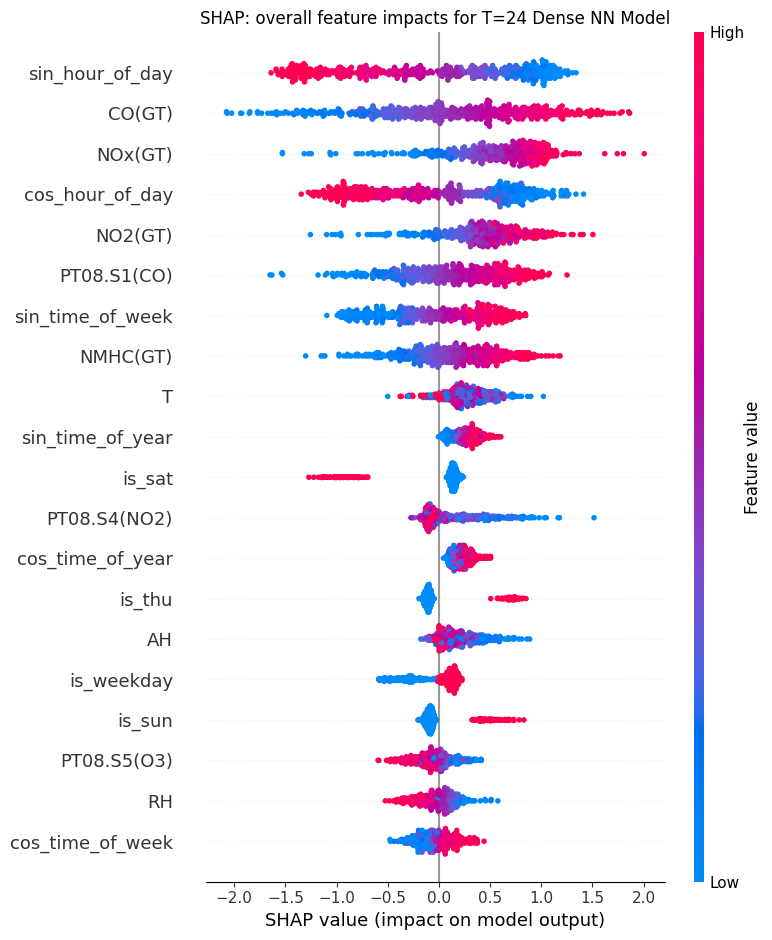

In [76]:
t = 24
epochs = 150
lr = 1e-5
t24_dense_model = Dense().to(device)
t_temporal_prediction(t24_dense_model, t, test_proportion, epochs, batch_size, lr, "dense", evaluate=True)
shap_graph(t24_dense_model, f"T={t} Dense NN Model")

# Final evaluation

In [ ]:
# evaluate a given model at t horizon and compare with ground truth
def evaluate(t, model, way):
    y_predicted = None
    model.eval()
    with torch.no_grad():
        test_data = torch.tensor(np.array(X_nontest, dtype=np.float32)).to(device)
        test_data = test_data[:-t]
        preds = model(test_data)
        y_predicted = preds.argmax(dim=1)

        test_labels = torch.tensor(np.array(y_nontest, dtype=np.float32)).to(device)
        test_labels = test_labels[t:]
    model.train()
    confusion_and_graph(t, test_labels.argmax(dim=1), y_predicted, way)

total=2246 correct=1690 T=1 Dense FNN accuracy=75.24%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([588, 113,  39])
tensor([103, 237, 197])
tensor([ 24,  80, 865])


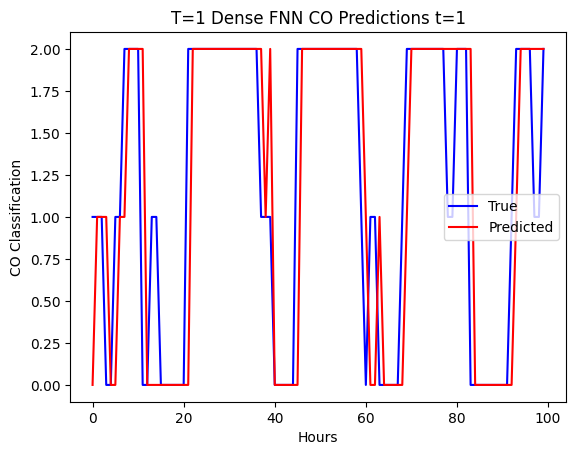

In [101]:
evaluate(1, t1_dense_model, "T=1 Dense FNN")

total=2241 correct=1463 T=6 Dense FNN accuracy=65.28%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([559,  41, 138])
tensor([193, 123, 218])
tensor([ 92,  96, 781])


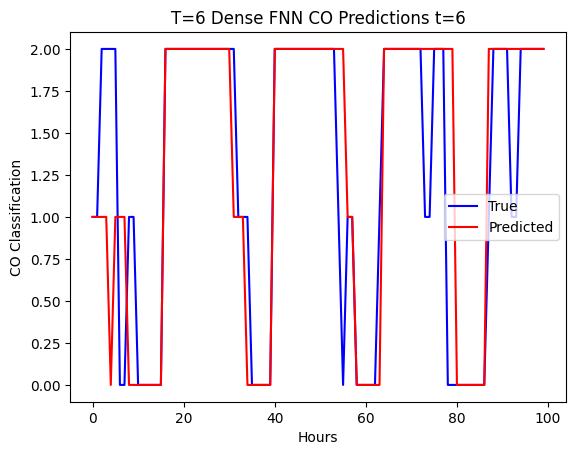

In [102]:
evaluate(6, t6_dense_model, "T=6 Dense FNN")

total=2235 correct=1364 T=12 Dense FNN accuracy=61.03%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([496,  20, 222])
tensor([211,  37, 284])
tensor([ 98,  36, 831])


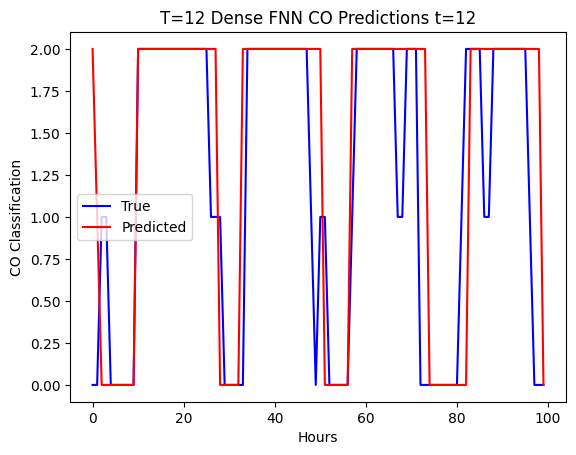

In [103]:
evaluate(12, t12_dense_model, "T=12 Dense FNN")

total=2223 correct=1421 T=24 Dense FNN accuracy=63.92%
confusion matrix (vertical axis=true, horizontal=predicted):
tensor([477, 110, 143])
tensor([138, 147, 245])
tensor([ 46, 120, 797])


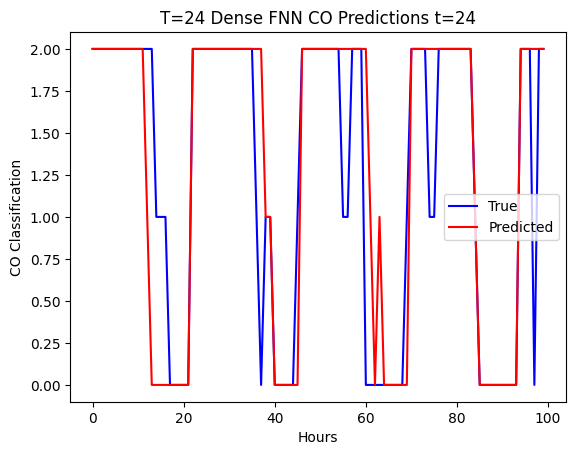

In [104]:
evaluate(24, t24_dense_model, "T=24 Dense FNN")